In [1]:
import sys
sys.path.append('..')

import quarantines as Q
import quarantines_mongo as qm 
import graph_generators as gg
import networkx as nx 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import utils
sns.set()

In [39]:
def get_topk_vs_prop(G, tau, gamma, num_init, k, get_bottom=False):
    """Takes a summary structure and returns a list of pairs of the form 
         [(#I+R, #topk), ...] where each pair is 
         p0: the number of I+R nodes infected when the i^th node in the topk% gets infected 
    """
    summary = Q.quarantine_by_prop(G, tau, gamma, num_init/len(G), [0], float('inf'), return_summary=True)[1][0]
    sorted_deg = sorted(dict(G.degree()).items(), key=lambda p: -p[1])
    # Get percentiles actually: 
    nodeset = set() 
    if not get_bottom:
        perc = sorted_deg[int(len(G) * k)][1]
        for node, deg in sorted_deg:
            if deg >= perc: 
                nodeset.add(node)
    else:
        perc = sorted_deg[-int(len(G) * k)][1]
        for node, deg in sorted_deg:
            if deg <= perc:
                nodeset.add(node)
            
    num_topk = 0
    output = []
    for idx, xmission in enumerate(summary.transmissions()):
        if xmission[-1] in nodeset:
            num_topk += 1
            output.append((idx / len(G), num_topk / len(nodeset)))
    return output




def groupwise_survivals(G, tau, gamma, num_init, k, get_bottom=False, num_iter=10):
    # Does the vertical smoothing for this as well 
    survivals = [get_topk_vs_prop(G, tau, gamma, num_init, k, get_bottom=get_bottom) for _ in range(num_iter)]
    unzipped = [list(zip(*_)) for _ in survivals]
    max_idx = max(enumerate(survivals), key=lambda p: p[1][-1][0])[0]
    proplist = [_[0] for _ in survivals[max_idx]]
    output = [] 
    for prop in proplist:
        sublist = []
        for xlist, ylist in unzipped:
            sublist.append(utils.linear_interp(xlist, ylist, prop))
        output.append(sublist)
        
    returnlist= [] 
    for prop, interplist in zip(proplist, output):
        returnlist.append((prop, np.mean(interplist), np.std(interplist)))
        
    return returnlist


In [59]:
def plot_subl(triplist, fig, ax, c, label):
    ax.plot(*utils.select_mean(triplist), color=c, label=label)
    ax.fill_between(*utils.plotfill_trips(triplist), color=c, alpha=0.2)
    

def experiment_synth(G, tau, gamma, num_init, num_iter, fig, ax):
    TOPK = [0.01, 0.03, 0.05]
    BOTTOMK = [0.05]
    top_survivals = {} 
    bottom_survivals = {}
    for k in TOPK:
        top_survivals[k] = groupwise_survivals(G, tau, gamma, num_init, k, num_iter=num_iter)
    for k in BOTTOMK:
        bottom_survivals[k] = groupwise_survivals(G, tau, gamma, num_init, k, get_bottom=True, num_iter=num_iter)
    
    i = 0 
    for k, triplist in top_survivals.items():
        kperc = round(k * 100)
        label = 'Top %s%%' %kperc
        plot_subl(triplist, fig, ax, utils.c(i), label)
        i += 1
    for k, triplist in bottom_survivals.items():
        kperc = round(k * 100)
        label = 'Bottom %s%%' %kperc
        plot_subl(triplist, fig, ax, utils.c(i), label)
        i += 1
    ax.plot([0.0, 1.0], [0.0, 1.], 'k--', alpha=0.5, label='Pop. Avg')
    ax.legend()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('%Population infected')
    ax.set_ylabel('%Group infected')
    return fig, ax

KeyboardInterrupt: 

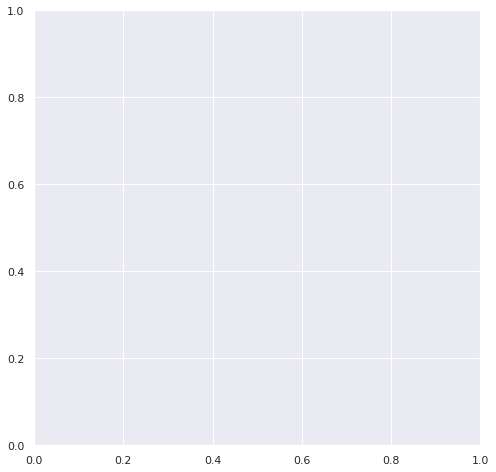

In [67]:
G = gg.ba_graph(10000, 10)
fig, ax = plt.subplots(figsize=(8,8))
fig, ax = experiment_synth(G, 0.5, 1, 10, 25, fig, ax)
ax.set_title("Groupwise Survival Rates | BA (N=10,000, m=10)")

Text(0.5, 1.0, 'Groupwise Survival Rates | GEMSEC FB.artist')

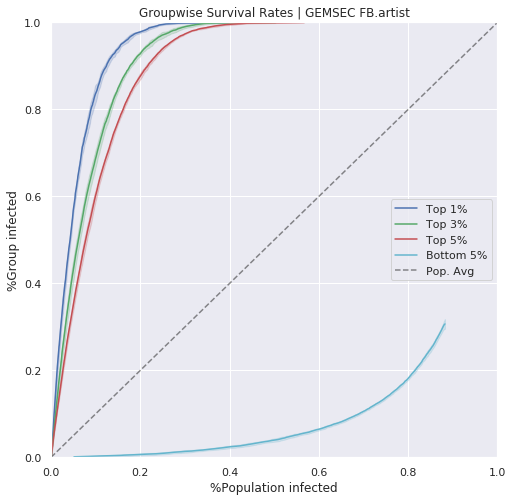

In [77]:
G = gg.load_gemsec_fb('artist')
fig, ax = plt.subplots(figsize=(8,8))
fig, ax = experiment_synth(G, 0.5, 1, 10, 5, fig, ax)
ax.set_title("Groupwise Survival Rates | GEMSEC FB.artist")